# HyperDrive demo notebook

This notebook will demostrate the use of the AzureML tool HyperDrive which allows for distributed hyperparameter tuning.

 Hyperparameters are used to control the training of a machine learning model and hyperparameter tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm for the specific application. This requires compiling and training a model over and over with different combinations of hyperparameters in a defined hyperparameter space, so the process can be very time intensive. Parallelising this processing can significantly increase the time efficiency of this process. 

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
import prd_pipeline

## Set up azure experiment


In [5]:
import azureml.core
from azureml.core import Workspace, Datastore, Dataset, Environment
from azureml.core import Experiment, ComputeTarget, ScriptRunConfig

In [6]:
prd_ws = Workspace.from_config()

In [7]:
import tensorflow

In [8]:
use_full_dataset = True
if use_full_dataset:
    azure_dataset_name ='prd_merged_all_events_files'
    prd_blob_rel_path = 'prd/*/prd_merged*csv'    
else:
    #  use subset for development.
    azure_dataset_name ='prd_merged_202110_nswws_amber_oct_files'
    prd_blob_rel_path = 'prd/202110_nswws_amber_oct/prd_merged*csv'    


In [9]:
use_gpu = True
if use_gpu:
    do_download_data = True # if false, use the azml dataset, otherwise download from datastore or blob store
    use_blob_store = True # only applies if do download is true. If this is true, download from the blob store rather than the datastore.
else:
    do_download_data = False # if false, use the azml dataset, otherwise download from datastore or blob store
    use_blob_store = False # only applies if do download is true. If this is true, download from the blob store rather than the datastore.

In [10]:
# this env has fsspec and related to facilitate loading data on GPU instance
azure_env_name = 'prd_ml_gpu_cluster'


In [11]:
if use_gpu:
    if use_full_dataset:
        cluster_name = 'prd-ml-fractions-cluster-gpu'
    else:
        cluster_name = 'mlops-gpu-test'
else:
    if use_full_dataset:
        cluster_name = 'prd-ml-fractions-cluster'
    else:
        cluster_name = 'mlops-test'
cluster_name

'prd-ml-fractions-cluster-gpu'

In [12]:
azure_experiment_name='prd_hyperdrive_cluster'

In [13]:
prd_model_name = 'azml_hpt_cluster'

In [14]:
target_parameter = 'radar_mean_rain_instant'
profile_features = ['air_temperature', 'relative_humidity']
single_lvl_features = ['air_pressure_at_sea_level'] 

In [15]:
prd_exp = Experiment(workspace=prd_ws, name=azure_experiment_name)
prd_exp

Name,Workspace,Report Page,Docs Page
prd_hyperdrive_cluster,precip_rediagnosis,Link to Azure Machine Learning studio,Link to Documentation


Get the AzML environment (basically a conda environment) from the workspace.

In [16]:
test_run = azureml.core.get_run(prd_exp, 'HD_18fd3ffb-6021-4845-88d0-e706c643a9fa')

In [17]:
test_run.get_best_run_by_primary_metric()

Experiment,Id,Type,Status,Details Page,Docs Page
prd_hyperdrive_cluster,HD_18fd3ffb-6021-4845-88d0-e706c643a9fa_0,azureml.scriptrun,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [18]:
prd_env = Environment.get(workspace=prd_ws, name=azure_env_name)
prd_env

{
    "assetId": "azureml://locations/uksouth/workspaces/57546dc9-9763-4025-831d-c19991c81540/environments/prd_ml_gpu_cluster/versions/1",
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/openmpi3.1.2-cuda10.2-cudnn8-ubuntu18.04",
        "baseImageRegistry": null,
        "buildContext": null,
        "enabled": false,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {},
    "inferencingStackVersion": null,
    "name": "prd_ml_gpu_cluster",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
                "conda-forge"
            ],
            "depen

In [19]:
import datetime
log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

### Execute our training run on a cluster with hyperdrive for parallelised hyperparameter tuning

In [20]:
from azureml.train.hyperdrive import GridParameterSampling, BanditPolicy, HyperDriveConfig, PrimaryMetricGoal, RandomParameterSampling
from azureml.train.hyperdrive import choice, loguniform

In [21]:
prd_demo_compute_target = ComputeTarget(workspace=prd_ws, name=cluster_name)
prd_demo_compute_target

AmlCompute(workspace=Workspace.create(name='precip_rediagnosis', subscription_id='07efdc52-cd27-48ed-9443-3aad2b6b777b', resource_group='precip_rediagnosis'), name=prd-ml-fractions-cluster-gpu, id=/subscriptions/07efdc52-cd27-48ed-9443-3aad2b6b777b/resourceGroups/precip_rediagnosis/providers/Microsoft.MachineLearningServices/workspaces/precip_rediagnosis/computes/prd-ml-fractions-cluster-gpu, type=AmlCompute, provisioning_state=Succeeded, location=uksouth, tags={})

Hyperparameters that we want to vary using hyperdrive need to be input arguments for the prd_cluster_train_demo.py script which is called through ScriptRunConfig. Hyperparameters set in prd_demo_args will be overwritten by Hyperdrive. 

In [22]:
nepochs = 1

In [23]:
prd_demo_args = ['--dataset-name', azure_dataset_name,
                 '--target-parameter', target_parameter,
                 '--model-name', prd_model_name,
                ]

prd_demo_args += ['--profile-features']
prd_demo_args += profile_features
prd_demo_args += ['--single-level_features']
prd_demo_args += single_lvl_features
prd_demo_args += ['--epochs', nepochs]
prd_demo_args += ['--batch-size', 128]
prd_demo_args += ['--learning-rate', 0.01]
prd_demo_args += ['--test-fraction', 0.2]
prd_demo_args += ['--log-dir', log_dir]


In [24]:
if do_download_data:
    if use_blob_store:
        prd_demo_args += ['--data-path', prd_blob_rel_path]
        prd_demo_args += ['--blob']    
    else:
        prd_demo_args += ['--data-path', azureml.core.Dataset.get_by_name(prd_ws, azure_dataset_name).as_download()]

In [25]:
prd_demo_args

['--dataset-name',
 'prd_merged_all_events_files',
 '--target-parameter',
 'radar_mean_rain_instant',
 '--model-name',
 'azml_hpt_cluster',
 '--profile-features',
 'air_temperature',
 'relative_humidity',
 '--single-level_features',
 'air_pressure_at_sea_level',
 '--epochs',
 1,
 '--batch-size',
 128,
 '--learning-rate',
 0.01,
 '--test-fraction',
 0.2,
 '--log-dir',
 'logs/fit/20221003-144819',
 '--data-path',
 'prd/*/prd_merged*csv',
 '--blob']

In [26]:
prd_run_src = ScriptRunConfig(source_directory=os.getcwd(),
                      script='prd_cluster_train_demo.py',
                      arguments=prd_demo_args,
                      compute_target=prd_demo_compute_target,
                      environment=prd_env)

### HyperDrive configuration

The next step is to configure our HyperDrive run. The run config defined above is passed to our HyperDriveConfig as the run_config. We must provide a <code>hyperparameter_sampling</code> explained in more detail below. We are required to also provide the <code>primary_metric_name</code> (either be the models loss function or a metric define when compiling the model) and the <code>primary_metric_goal</code> to either minimize or maximize this metric. We must also define <code>max_total_runs</code> (the upper bound of the number of runs, may be smaller depending on the defined hyperparameter space and sampling strategy) and <code>max_concurrent_runs</code>, if this is set to None all run are launched in parallel.
There is also the option to define an early stopping policy with the <code>policy</code> argument.

#### Hyperparameter sampling

There are three different classes for sampling the hyperparameter space: 
- <code>GridParameterSampling</code>: define a search space as a grid of hyperparameter based on the given hyperparameter space, then evaluates every position in the grid in order (note if max_total_runs < total potential combinations, then this will only run a subsample of the grid).
- <code>RandomParameterSampling</code>: randomly samples hyperparameter combinations from the hyperparameter space 
- <code>BayesianParameterSampling</code>: defines Bayesian sampling over a hyperparameter space, tries to intelligently pick the next sample of hyperparameters based on how the previous samples performed.

We then define the hyperparameter space from which to select the combination of hyperparameters to assess. The hyperparameters that we want to tune should be input arguments to the script which is being run by ScriptRunConfig and any hyperparameter arguments that are input will be overwritten by hyperdrive.

In AzureML, there are different ways to define the set to sample each hyperparameters from (<code>choice</code>, <code>lognormal</code>, <code>loguniform</code>, <code>normal</code>, <code>qlognormal</code>, <code>qloguniform</code>, <code>qnormal</code>, <code>quniform</code>, <code>randint</code> and <code>uniform</code>).

In [27]:
ps = RandomParameterSampling(
    {
        '--batch-size': choice(32, 64, 128),
        '--learning-rate': loguniform(-6, -1)
    }
)

#### Early stopping policy

We can define an early stopping policy in which means that any poorly performing experiment runs are canceled and new ones started. Here we use BanditPolicy with a slack criteria of 0.1 (the ratio of slack allowed with respect to the best performing training run) and evaluation internal of 2 (the frequency for applying the policy, here every two training steps).

In [28]:
early_stop_policy = BanditPolicy(evaluation_interval=2, slack_factor=0.1)

In [29]:
htc = HyperDriveConfig(run_config=prd_run_src, 
                       hyperparameter_sampling=ps, 
                       policy=early_stop_policy, 
                       primary_metric_name='mean_absolute_error', 
                       primary_metric_goal=PrimaryMetricGoal.MINIMIZE, 
                       max_total_runs=4,
                       max_concurrent_runs=4)

### HyperDrive running

In [30]:
prd_run = prd_exp.submit(htc)
prd_run

Experiment,Id,Type,Status,Details Page,Docs Page
prd_hyperdrive_cluster,HD_6d5cc8ee-f92a-43e5-ad9e-248bcec43a6b,hyperdrive,Running,Link to Azure Machine Learning studio,Link to Documentation


In [31]:
prd_run.wait_for_completion()
assert(prd_run.get_status() == "Completed")

### HyperDrive results

We can then select the model which performs best against the selected primary metric, as defined within the HyperDriveConfig.

In [32]:
prd_best_run = prd_run.get_best_run_by_primary_metric()
prd_best_run

Experiment,Id,Type,Status,Details Page,Docs Page
prd_hyperdrive_cluster,HD_6d5cc8ee-f92a-43e5-ad9e-248bcec43a6b_0,azureml.scriptrun,Completed,Link to Azure Machine Learning studio,Link to Documentation


We can also return information from each of the different hyperdrive child run

In [33]:
prd_best_run

Experiment,Id,Type,Status,Details Page,Docs Page
prd_hyperdrive_cluster,HD_6d5cc8ee-f92a-43e5-ad9e-248bcec43a6b_0,azureml.scriptrun,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [34]:
import tempfile

In [35]:
with tempfile.TemporaryDirectory() as td1:
    td_path = pathlib.Path(td1)
    print(td_path)
    prd_best_run.download_files(prefix=prd_model_name, output_directory=td1)
    model_path = td_path / prd_model_name
    print(model_path)
    list(model_path.iterdir())
    trained_model = tensorflow.keras.models.load_model(model_path)
trained_model

/tmp/tmp82weozfu
/tmp/tmp82weozfu/azml_hpt_cluster


2022-10-03 14:54:44.908158: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [36]:
trained_model

### Load the data for inference

Load the data from the same loading functions as in the script for consistencyt

In [37]:
import json

In [38]:
with open('credentials_file.json') as credentials_file:
    az_blob_cred = json.load(credentials_file)
    
az_blob_cred.keys()

dict_keys(['storage_acc_name', 'storage_acc_key', 'container'])

In [39]:
%%time
input_data = prd_pipeline.load_data_azure_blob(
    az_blob_cred=az_blob_cred,
    blob_path=prd_blob_rel_path,
)


loading data direct from blobstore
CPU times: user 38.7 s, sys: 3.2 s, total: 41.9 s
Wall time: 1min 21s


In [40]:
%%time
data_splits, data_dims = prd_pipeline.preprocess_data(
    input_data,
    feature_dict={'profile': profile_features, 'single_level': single_lvl_features,'target': target_parameter,},
    test_fraction=0.2, 
)

target has dims: 23
dropping zeros
getting profile columns
['relative_humidity_5.0', 'relative_humidity_10.0', 'relative_humidity_20.0', 'relative_humidity_30.0', 'relative_humidity_50.0', 'relative_humidity_75.0', 'relative_humidity_100.0', 'relative_humidity_150.0', 'relative_humidity_200.0', 'relative_humidity_250.0', 'relative_humidity_300.0', 'relative_humidity_400.0', 'relative_humidity_500.0', 'relative_humidity_600.0', 'relative_humidity_700.0', 'relative_humidity_800.0', 'relative_humidity_1000.0', 'relative_humidity_1250.0', 'relative_humidity_1500.0', 'relative_humidity_1750.0', 'relative_humidity_2000.0', 'relative_humidity_2250.0', 'relative_humidity_2500.0', 'relative_humidity_2750.0', 'relative_humidity_3000.0', 'relative_humidity_3250.0', 'relative_humidity_3500.0', 'relative_humidity_3750.0', 'relative_humidity_4000.0', 'relative_humidity_4500.0', 'relative_humidity_5000.0', 'relative_humidity_5500.0', 'relative_humidity_6000.0', 'air_temperature_5.0', 'air_temperature

### Explore metrics and do inference

In [41]:
y_pred = trained_model.predict(data_splits['X_val'])

In [42]:
y_pred

array([[0.24498479],
       [0.24498479],
       [0.24498479],
       ...,
       [0.24498479],
       [0.24498479],
       [0.24498479]], dtype=float32)

Text(0, 0.5, 'Predicted 3hr precip_accumulation value')

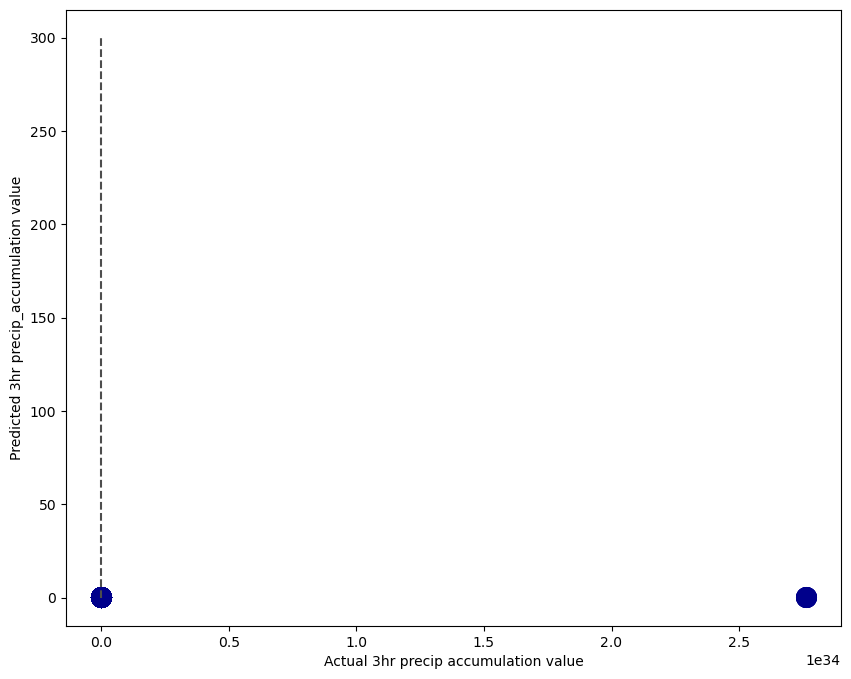

In [43]:
fig1 = plt.figure(figsize=(10, 8))
ax1 = fig1.add_subplot(1,1,1)
ax1.scatter(data_splits['y_val'], y_pred, s=200, c='darkblue')
ax1.plot([0, 300], [0, 300], ls="--", c=".3")
ax1.set_xlabel('Actual 3hr precip accumulation value')
ax1.set_ylabel('Predicted 3hr precip_accumulation value')

In [44]:
prd_run.get_children_sorted_by_primary_metric()

[{'run_id': 'HD_6d5cc8ee-f92a-43e5-ad9e-248bcec43a6b_0',
  'hyperparameters': '{"--batch-size": 128, "--learning-rate": 0.17020130626599278}',
  'best_primary_metric': 8.482864144322285e+29,
  'status': 'Completed'},
 {'run_id': 'HD_6d5cc8ee-f92a-43e5-ad9e-248bcec43a6b_2',
  'hyperparameters': '{"--batch-size": 128, "--learning-rate": 0.04633640312451929}',
  'best_primary_metric': 1.272429621648343e+30,
  'status': 'Completed'},
 {'run_id': 'HD_6d5cc8ee-f92a-43e5-ad9e-248bcec43a6b_3',
  'hyperparameters': '{"--batch-size": 128, "--learning-rate": 0.19772259459002325}',
  'best_primary_metric': 1.696572828864457e+30,
  'status': 'Completed'},
 {'run_id': 'HD_6d5cc8ee-f92a-43e5-ad9e-248bcec43a6b_1',
  'hyperparameters': '{"--batch-size": 32, "--learning-rate": 0.0030335241109855663}',
  'best_primary_metric': 2.544859243296686e+30,
  'status': 'Completed'}]

In [45]:
prd_run.get_metrics()

{'HD_6d5cc8ee-f92a-43e5-ad9e-248bcec43a6b_2': {'mean_absolute_error': 1.272429621648343e+30,
  'R-squared score': -4.607870242412382e-05},
 'HD_6d5cc8ee-f92a-43e5-ad9e-248bcec43a6b_1': {'mean_absolute_error': 2.544859243296686e+30,
  'R-squared score': -9.216165153724809e-05},
 'HD_6d5cc8ee-f92a-43e5-ad9e-248bcec43a6b_3': {'mean_absolute_error': 1.696572828864457e+30,
  'R-squared score': -6.143921357804061e-05},
 'HD_6d5cc8ee-f92a-43e5-ad9e-248bcec43a6b_0': {'mean_absolute_error': 8.482864144322285e+29,
  'R-squared score': -3.071866312454041e-05}}

In [46]:
test_run.get_metrics()

{'HD_18fd3ffb-6021-4845-88d0-e706c643a9fa_0': {'mean_absolute_error': 14.027489237225254,
  'R-squared score': 0.586384162867827},
 'HD_18fd3ffb-6021-4845-88d0-e706c643a9fa_1': {'mean_absolute_error': 14.818366171589505,
  'R-squared score': 0.49815163454629796},
 'HD_18fd3ffb-6021-4845-88d0-e706c643a9fa_3': {'mean_absolute_error': 14.964776840180555,
  'R-squared score': 0.5118016772403515},
 'HD_18fd3ffb-6021-4845-88d0-e706c643a9fa_2': {'mean_absolute_error': 14.473514401967618,
  'R-squared score': 0.5935323290592469}}

In [47]:
prd_run.get_hyperparameters()

{'HD_6d5cc8ee-f92a-43e5-ad9e-248bcec43a6b_0': '{"--batch-size": 128, "--learning-rate": 0.17020130626599278}',
 'HD_6d5cc8ee-f92a-43e5-ad9e-248bcec43a6b_1': '{"--batch-size": 32, "--learning-rate": 0.0030335241109855663}',
 'HD_6d5cc8ee-f92a-43e5-ad9e-248bcec43a6b_2': '{"--batch-size": 128, "--learning-rate": 0.04633640312451929}',
 'HD_6d5cc8ee-f92a-43e5-ad9e-248bcec43a6b_3': '{"--batch-size": 128, "--learning-rate": 0.19772259459002325}'}

In [48]:
test_run.get_hyperparameters()

{'HD_18fd3ffb-6021-4845-88d0-e706c643a9fa_0': '{"--batch-size": 32, "--learning-rate": 0.001}',
 'HD_18fd3ffb-6021-4845-88d0-e706c643a9fa_1': '{"--batch-size": 32, "--learning-rate": 0.01}',
 'HD_18fd3ffb-6021-4845-88d0-e706c643a9fa_2': '{"--batch-size": 64, "--learning-rate": 0.001}',
 'HD_18fd3ffb-6021-4845-88d0-e706c643a9fa_3': '{"--batch-size": 64, "--learning-rate": 0.01}'}